This notebook aims to demonstrate the different ways to use the MTCNN face detection module of `facenet-pytorch`. Originally reported in [Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks](https://arxiv.org/abs/1604.02878), the MTCNN network is able to simultaneously propose bounding boxes, five-point facial landmarks, and detection probabilities. Taken from the original paper:

> Face detection and alignment in unconstrained environments are challenging due to various poses, illuminations and occlusions. Recent studies show that deep learning approaches can achieve impressive performance on these two tasks. In this paper, we propose a deep cascaded multi-task framework which exploits the inherent correlation between them to boost up their performance. In particular, our framework adopts a cascaded structure with three stages of carefully designed deep convolutional networks that predict face and landmark location in a coarse-to-fine manner. In addition, in the learning process, we propose a new online hard sample mining strategy that can improve the performance automatically without manual sample selection. Our method achieves superior accuracy over the state-of-the-art techniques on the challenging FDDB and WIDER FACE benchmark for face detection, and AFLW benchmark for face alignment, while keeps real time performance.

`facenet-pytorch` includes an efficient, cuda-ready implementation of MTCNN that will be demonstrated in this notebook. The following topics will be covered:

1. <a href='#1'>Documentation</a>
1. <a href='#2'>Basic usage</a>
1. <a href='#3'>Preventing image normalization</a>
1. <a href='#4'>Margin adjustment</a>
1. <a href='#5'>Multiple faces in a single image</a>
1. <a href='#6'>Batched detection</a>
1. <a href='#7'>Bounding boxes and facial landmarks</a>
1. <a href='#8'>Saving face datasets</a>

Other resources:

1. The facenet-pytorch [github repo](https://github.com/timesler/facenet-pytorch)
1. [Notebook demonstrating combined use of face detection and recognition](https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch)
1. [The FastMTCNN algorithm](https://www.kaggle.com/timesler/fast-mtcnn-detector-45-fps-at-full-resolution) 

In [1]:
%%capture
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl

In [2]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# <a id='1'>Documentation</a>

Detailed usage information is contained in the MTCNN docstring:

```
help(MTCNN)
```

# <a id='2'>Basic usage</a>

Unlike other implementations, calling a `facenet-pytorch` MTCNN object directly with an image (i.e., using the forward method for those familiar with pytorch) will return torch tensors containing the detected face(s), rather than just the bounding boxes. This is to enable using the module easily as the first stage of a facial recognition pipeline, in which the faces are passed directly to an additional network or algorithm.

In order to return the detected boxes instead (and optionally, the facial landmarks), see the `MTCNN.detect()` method. Its use will be described below also.

To create an MTCNN detector that runs on the GPU, instantiate the model with `device='cuda:0'` or equivalent.

For this competition, it will be best to set `select_largest=False` to ensure detected faces are ordered according to detection probability rather than size.

torch.Size([3, 160, 160])

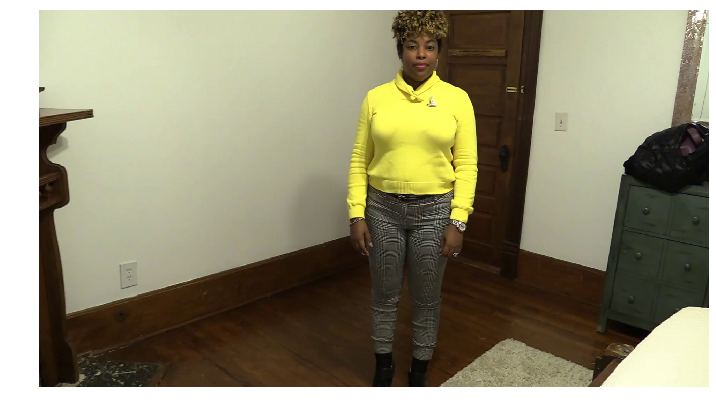

In [3]:
# Create face detector
mtcnn = MTCNN(select_largest=False)

# Load a single image and display
v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/agqphdxmwt.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')

# Detect face
face = mtcnn(frame)
face.shape

# <a id='3'>Preventing image normalization</a>

By default, the MTCNN module of `facenet-pytorch` applies fixed image standardization to faces before returning so they are well suited for the package's face recognition model.

If you want to get out images that look more normal to the human eye, this normalization can be prevented by creating the detector with `post_process=False`.

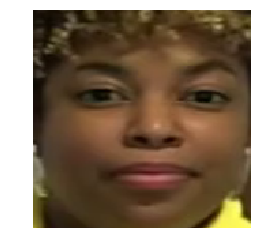

In [4]:
# Create face detector
mtcnn = MTCNN(select_largest=False, post_process=False, device='cuda:0')

# Detect face
face = mtcnn(frame)

# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off');

# <a id='4'>Margin adjustment</a>

Depending on your downstream processing and how fakes can be identified, you may want to add more (or less) of a margin around the detected faces. This is controlled using the `margin` argument.

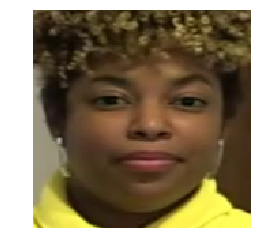

In [5]:
# Create face detector
mtcnn = MTCNN(margin=40, select_largest=False, post_process=False, device='cuda:0')

# Detect face
face = mtcnn(frame)

# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off');

# <a id='5'>Multiple faces in a single image</a>

Using MTCNN as above will only return a single face from each frame (or None if none are detected). Since some of the videos in the dataset contain more than one face, you will likely want to return all detected faces as any/all of them may have been modified. This is acheived by setting `keep_all=True`

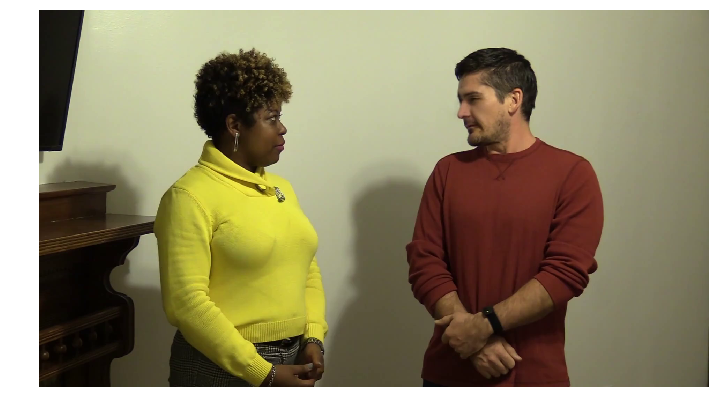

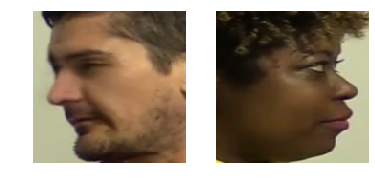

In [6]:
# Create face detector
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')

# Load a single image and display
v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/avibnnhwhp.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

# Detect face
faces = mtcnn(frame)

# Visualize
fig, axes = plt.subplots(1, len(faces))
for face, ax in zip(faces, axes):
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.axis('off')
fig.show()

# <a id='6'>Batched detection</a>

`facenet-pytorch` is also capable of performing face detection on batches of images, typically providing considerable speed-up. A batch should be structured as list of PIL images of equal dimension. The returned object will have an additional first dimension corresponding to the batch. Each image in the batch may have one or more faces detected.

In the following example, we use MTCNN to detect multiple faces in:
1. A single batch of frames, and
1. Every frame of a video

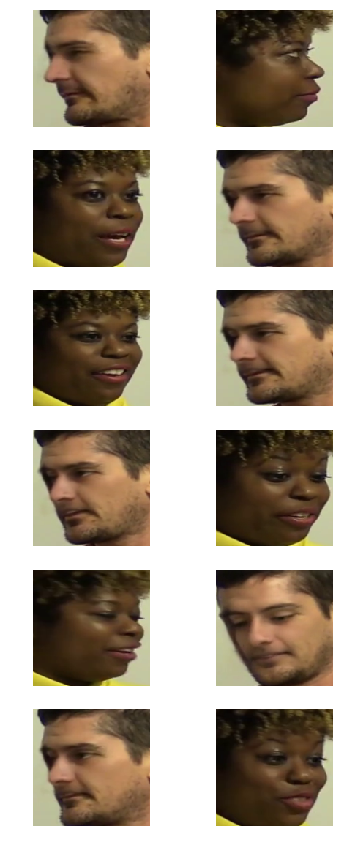

In [7]:
# Create face detector
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')

# Load a video
v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/avibnnhwhp.mp4')
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Loop through video, taking a handful of frames to form a batch
frames = []
for i in tqdm(range(v_len)):
    
    # Load frame
    success = v_cap.grab()
    if i % 50 == 0:
        success, frame = v_cap.retrieve()
    else:
        continue
    if not success:
        continue
        
    # Add to batch
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))

# Detect faces in batch
faces = mtcnn(frames)

fig, axes = plt.subplots(len(faces), 2, figsize=(6, 15))
for i, frame_faces in enumerate(faces):
    for j, face in enumerate(frame_faces):
        axes[i, j].imshow(face.permute(1, 2, 0).int().numpy())
        axes[i, j].axis('off')
fig.show()

The following example uses a similar approach to detect all faces in all frames in a video.

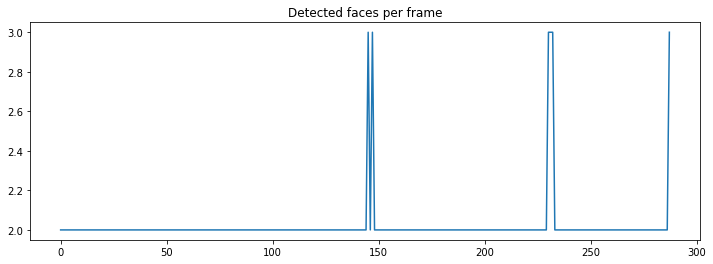

In [8]:
# Load a video
v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/avibnnhwhp.mp4')
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Loop through video
batch_size = 16
frames = []
faces = []
for _ in tqdm(range(v_len)):
    
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        faces.extend(mtcnn(frames))
        frames = []

plt.figure(figsize=(12, 4))
plt.plot([len(f) for f in faces])
plt.title('Detected faces per frame');

# <a id='7'>Bounding boxes and facial landmarks</a>

To return bounding boxes and facial landmarks from MTCNN, instead of calling the `mtcnn` object directly, call `mtcnn.detect()` instead.

Unlike the forward method (shown in each of examples above), the `.detect()` method will always return all detected bounding boxes (and optional landmarks) in an image.

The following example demonstrates the use of the `.detect()` method on a single image.

Note that the `margin` argument, if used when creating the MTCNN detector, is not used in the `detect()` method. `detect()` returns the true bounding boxes, so the margin can be applied subsequently by the user if desired.

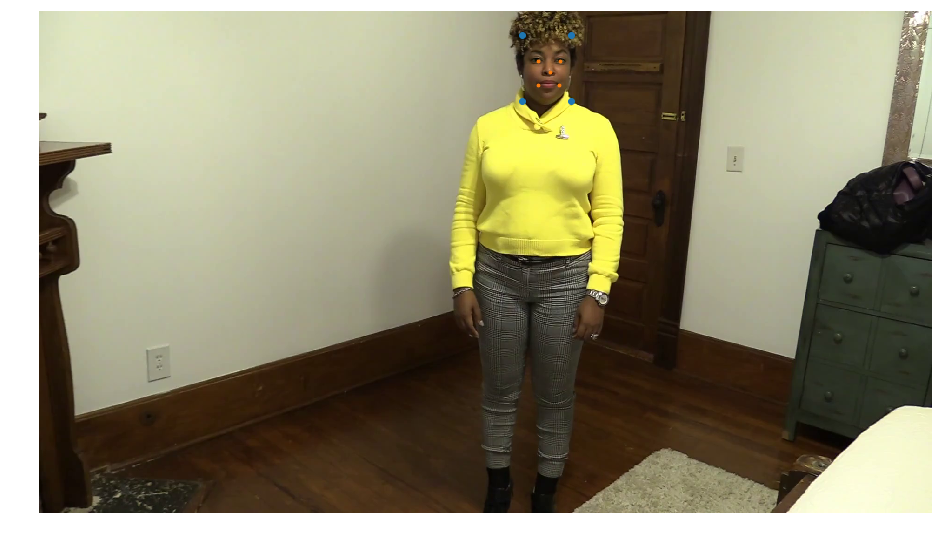

In [9]:
# Create face detector
mtcnn = MTCNN(keep_all=True, device='cuda:0')

# Load a single image and display
v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/agqphdxmwt.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

# Detect face
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

The following example demonstrates how to show bounding boxes and facial landmarks in every frame in a video.

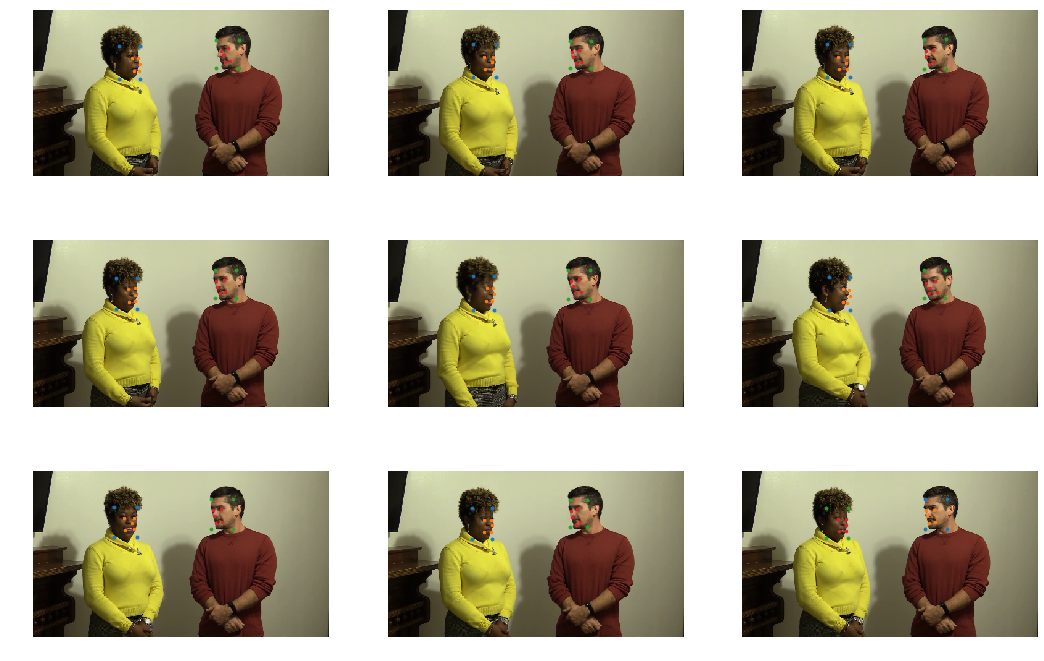

In [10]:
# Load a video
v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/avibnnhwhp.mp4')

# Loop through video
batch_size = 32
frames = []
boxes = []
landmarks = []
view_frames = []
view_boxes = []
view_landmarks = []
for _ in tqdm(range(v_len)):
    
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch, resizing for speed
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.resize([int(f * 0.25) for f in frame.size])
    frames.append(frame)
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        batch_boxes, _, batch_landmarks = mtcnn.detect(frames, landmarks=True)
        boxes.extend(batch_boxes)
        landmarks.extend(batch_landmarks)
        
        view_frames.append(frames[-1])
        view_boxes.append(boxes[-1])
        view_landmarks.append(landmarks[-1])
        
        frames = []

# Visualize
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
for i in range(9):
    ax[int(i / 3), i % 3].imshow(view_frames[i])
    ax[int(i / 3), i % 3].axis('off')
    for box, landmark in zip(view_boxes[i], view_landmarks[i]):
        ax[int(i / 3), i % 3].scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]), s=8)
        ax[int(i / 3), i % 3].scatter(landmark[:, 0], landmark[:, 1], s=6)

# <a id='8'>Saving face datasets</a>

In order to save detected faces directly to file, use MTCNN's `save_path` argument in the forward function. This is compatible with both single images and batch processing.

- For single images, pass a single path string (e.g., '{videoname}\_{frame}.jpg')
- For batches of images, pass a list of path strings (one for each frame)

When multiple faces are detected in a single image, additional faces are each saved with an incremental integer appended to the end of the save path (e.g., '{videoname}\_{frame}.jpg' and '{videoname}\_{frame}\_1.jpg')

See example below.

In [11]:
# Single image
mtcnn(frame, save_path='single_image.jpg');

# Batch
save_paths = [f'image_{i}.jpg' for i in range(len(frames))]
mtcnn(frames, save_path=save_paths);